In [ ]:
from util import get_image_by_index, decode_class
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Load the .npz file
data = np.load('dataset_features.npz')

# List all arrays within the .npz file
print(data.files)

# Access individual arrays by their names
X_train = data['trainset_features']
y_train = data['trainset_labels']

X_val = data['validset_features']
y_val = data['validset_labels']

X_test = data['testset_features']
y_test = data['testset_labels']

class_labels = data['class_labels']

2024-11-24 21:26:47.234902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-24 21:26:47.235150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


['trainset_features', 'validset_features', 'testset_features', 'trainset_labels', 'validset_labels', 'testset_labels', 'class_labels']


## Decision tree with depth of 3

In [ ]:
dtree = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=0)

In [45]:
# Fit decision tree
dtree.fit(X_train, y_train)

print('Model Accuracy:')
print(f'On train set: {dtree.score(X_train, y_train):.3f}')
print(f'On valid set: {dtree.score(X_val, y_val):.3f}')
print(f'On test  set: {dtree.score(X_test, y_test):.3f}')

Model Accuracy:
On train set: 0.618
On valid set: 0.525
On test  set: 0.520


Visualization of decision tree

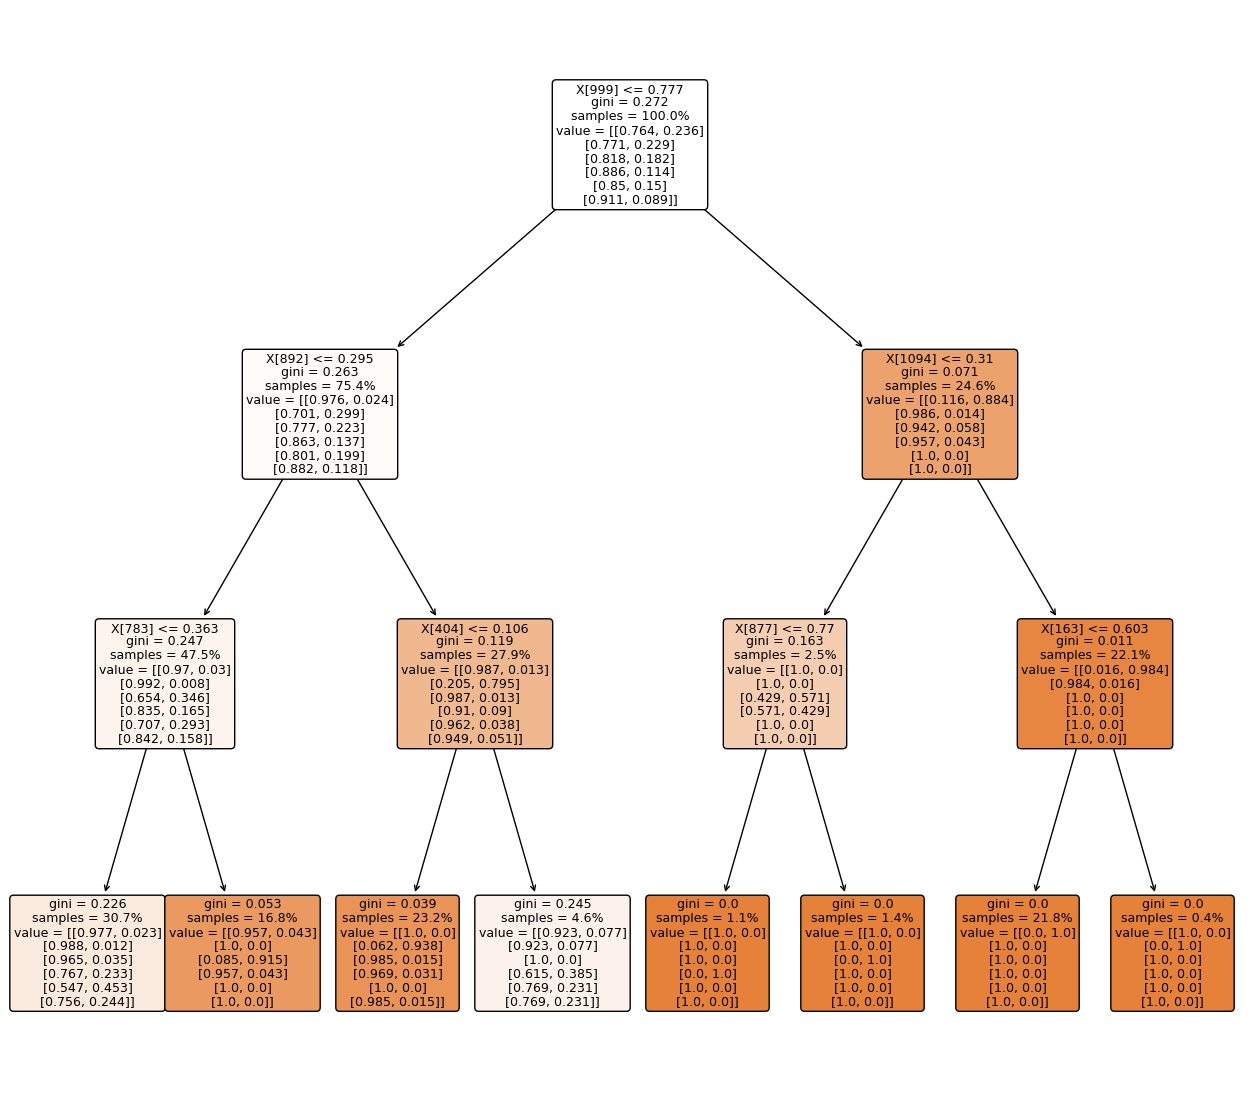

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 14))
plot_tree(
    dtree,
    filled=True,
    rounded=True,
    proportion=True,
    class_names=class_labels,
)
plt.show()

## Tuning of model depth (using cross-validation)

In [25]:
X_crossval = np.concatenate((X_train, X_val), axis=0)
y_crossval = decode_class(np.concatenate((y_train, y_val), axis=0))

In [39]:
from sklearn.model_selection import GridSearchCV

# Define grid of regularization strengths to test
param_grid = {
    'max_depth': np.linspace(1, 12, 12)  # Test values from 10^-4 to 10^4
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    scoring='accuracy',  # Metric for evaluating models
    cv=5,                # 5-fold cross-validation
    n_jobs=-1,           # Use all available processors
    return_train_score=True
)

# Perform grid search
grid_search.fit(X_crossval, y_crossval)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])},
             return_train_score=True, scoring='accuracy')

In [40]:
import pandas as pd

# Extract results from the GridSearchCV object
results = pd.DataFrame(grid_search.cv_results_)

# Select relevant columns for interpretation
results_df = results[
    [
        'param_max_depth',  # Regularization strength parameter
        'mean_train_score',  # Mean training score across folds
        'std_train_score',  # Standard deviation of training score across folds
        'mean_test_score',  # Mean validation (test) score across folds
        'std_test_score'  # Standard deviation of validation score across folds
    ]
]

# Sort by the validation score for better interpretability
results_df = results_df.sort_values(by='mean_test_score', ascending=False)
results_df

,param_max_depth,mean_train_score,std_train_score,mean_test_score,std_test_score
4,5.0,0.914670,0.012078,0.730264,0.025015
8,9.0,0.997612,0.003481,0.706426,0.018065
6,7.0,0.981494,0.010582,0.701721,0.011849
5,6.0,0.954049,0.011444,0.701692,0.023503
3,4.0,0.832333,0.015093,0.701606,0.016311
9,10.0,0.999403,0.001194,0.699283,0.019012
10,11.0,1.000000,0.000000,0.699283,0.019012
11,12.0,1.000000,0.000000,0.699283,0.019012
2,3.0,0.761931,0.005853,0.694464,0.015241
7,8.0,0.992836,0.006147,0.675473,0.014626


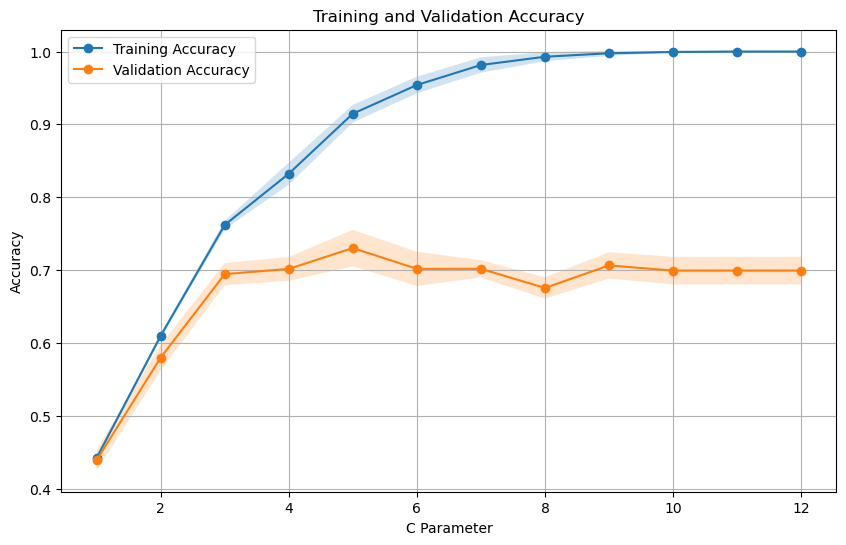

In [ ]:
# Assuming you have metrics recorded during training, such as accuracy or loss
# Example data (replace with actual metrics from your training process)

results_df = results_df.sort_values(by='param_max_depth')

param_max_depth = results_df['param_max_depth'].to_numpy()
train_scores_mean = results_df['mean_train_score'].to_numpy()
val_scores_mean = results_df['mean_test_score'].to_numpy()
train_scores_std = results_df['std_train_score'].to_numpy()
val_scores_std = results_df['std_test_score'].to_numpy()

# Plot the curves
plt.figure(figsize=(10, 6))
plt.plot(param_max_depth, train_scores_mean, label="Training Accuracy", marker="o")
plt.plot(param_max_depth, val_scores_mean, label="Validation Accuracy", marker="o")
plt.fill_between(param_max_depth, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(param_max_depth, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)
plt.title("Training and Validation Accuracy")
plt.xlabel("C Parameter")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

We observee that at depth>=3 the model starts to overfit. Nevertheless the optimal accuracy in the validation sets corresponds to depth=5

In [55]:
dtree.set_params(max_depth=5)

# Fit decision tree
dtree.fit(X_train, y_train)

print('Model Accuracy:')
print(f'On train set: {dtree.score(X_train, y_train):.3f}')
print(f'On valid set: {dtree.score(X_val, y_val):.3f}')
print(f'On test  set: {dtree.score(X_test, y_test):.3f}')

Model Accuracy:
On train set: 0.875
On valid set: 0.691
On test  set: 0.680


Which slightly increases the model accuracy also on the test dataset

## Two step model with PCA then random forest (re-check this)

In [57]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# Define the pipeline with PCA and Decision Tree
pipeline = Pipeline([
    ('pca', PCA()),  # PCA step
    ('dtree', DecisionTreeClassifier())  # Decision tree step
])

# Define a grid for PCA components and decision tree parameters
param_grid = {
    'pca__n_components': [5, 10, 15, 20],  # Number of PCA components to test
    'dtree__max_depth': [5, 10, 15, None]  # Decision tree depths to test
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the pipeline to the data
grid_search.fit(X_crossval, y_crossval)

# Get the best parameters and model
best_pipeline = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated Accuracy: {grid_search.best_score_}")

# Evaluate the best model on the test set
y_pred = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with PCA: {test_accuracy}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'dtree__max_depth': 5, 'pca__n_components': 5}
Best Cross-Validated Accuracy: 0.9021514629948365


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define Random Forest model
rf = RandomForestClassifier(random_state=0)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees to test
    'max_depth': [5, 10, 20, None]  # Tree depths to test
}

# Set up GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search_rf.fit(X_crossval, y_crossval)

# Best parameters and model
best_rf = grid_search_rf.best_estimator_
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Best Cross-Validated Accuracy: {grid_search_rf.best_score_}")

# Evaluate the model on the test set
y_test_pred = best_rf.predict(X_test)
rf_test_accuracy = accuracy_score(decode_class(y_test), y_test_pred)
print(f"Test Accuracy with Random Forest: {rf_test_accuracy}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'max_depth': 5, 'n_estimators': 50}
Best Cross-Validated Accuracy: 0.8855134825014342
Test Accuracy with Random Forest: 0.92


In [67]:
type(X_crossval)

numpy.ndarray

In [72]:
X_crossval.shape[1]

1280

In [76]:
# Get feature importances
feature_importances = best_rf.feature_importances_

# Create a DataFrame to store feature names and their importance scores
features_df = pd.DataFrame({
    'Feature': np.arange(X_crossval.shape[1]),  # Replace with feature names if X_train is a DataFrame
    'Importance': feature_importances
})

# Sort features by importance
top_features = features_df.sort_values(by='Importance', ascending=False).head(5)
top_features

,Feature,Importance
1239,1239,0.030310
466,466,0.029950
1197,1197,0.018522
892,892,0.017892
505,505,0.017810


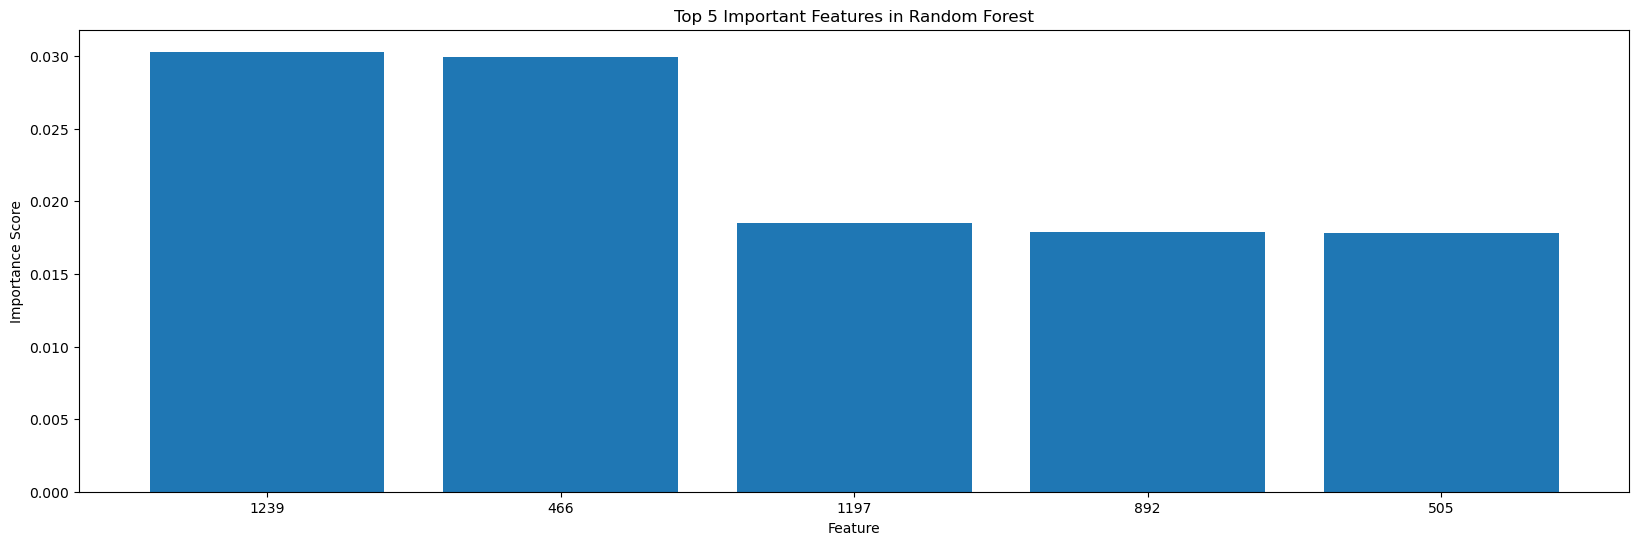

In [90]:

# Visualize the top 5 important features
plt.figure(figsize=(20, 6))
plt.bar(range(5), top_features['Importance'])
plt.xticks(range(5), top_features['Feature'])
plt.title('Top 5 Important Features in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.show()

Differences arise due to the models’ nature—linear vs. nonlinear and how they handle feature interactions.